# Segmentation

One of the approaches that we aimed to try was to use segmentation to detect coins from images and based on the predicted binary mask, we can localize them and use this as input to feature extraction and classification. We will experiment with classic **Unet encoder** with pretrained **ResNet backbone** (decoder).

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch

import cv2 as cv
import numpy as np
import albumentations as A
import segmentation_models_pytorch as smp

from scripts.viz import plot_images
from scripts.training import train_model, get_best_available_device
from scripts.utils import SegmentationDataset, split_data, get_prediction, filter_circles

from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torch.utils.data import DataLoader

## Hyperparameters and Config

In [5]:
# let's specify paths to training images and masks
seg_directory = "data/segmentation"

In [6]:
# training hyperparameters
num_epochs = 20
batch_size = 4
lr = 0.005

## Data Augmentation

We first define data augmentations for more robust model, then generate datasets and dataloaders for training and validation.

In [7]:
# define data augmentation for train and validation
train_tf = A.Compose([
    A.Resize(width=600, height=400, always_apply=True),
    A.PadIfNeeded(min_height=416, min_width=608, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.RandomGamma(gamma_limit=(80, 120), p=0.4),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4)
])

valid_tf = A.Compose([
    A.Resize(width=600, height=400, always_apply=True),
    A.PadIfNeeded(min_height=416, min_width=608, always_apply=True),
])

# get bacbbone specific transformations
preprocess_input = get_preprocessing_fn('resnet50', pretrained='imagenet')

In [8]:
# split the image paths into train and validation
image_path_train, image_path_val, mask_path_train, mask_path_val \
    = split_data(seg_directory, 0.2, 'segmentation')

# get train and val dataset instances
train_ds = SegmentationDataset(
    image_paths=image_path_train,
    mask_paths=mask_path_train,
    transform=train_tf,
    # preprocess=preprocess_input
)

val_ds = SegmentationDataset(
    image_paths=image_path_val,
    mask_paths=mask_path_val,
    transform=valid_tf,
    # preprocess=preprocess_input
)

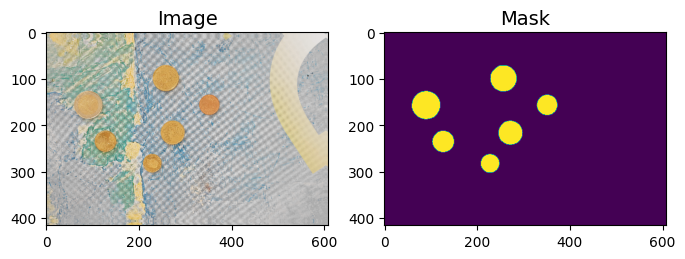

In [9]:
img, mask = train_ds[7]
plot_images(image=img, mask=mask.squeeze(0))

In [10]:
# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

## Modelling

We use `Segmentation Models Pytorch` for model generation, then we define training arguments and train the model

In [11]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

# freeze encoder weights
model.encoder.training = False

In [12]:
trainable_params = [param for param in model.parameters() if param.requires_grad == True]
optimizer = torch.optim.Adam(trainable_params, lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

In [ ]:
# train the model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs
)

In [ ]:
torch.save(model.state_dict(), 'segmentation_20eps.pt')

## Inference

Let's see how well the model does.

In [22]:
model.load_state_dict(torch.load('segmentation_20eps.pt'))
model = model.to(get_best_available_device())

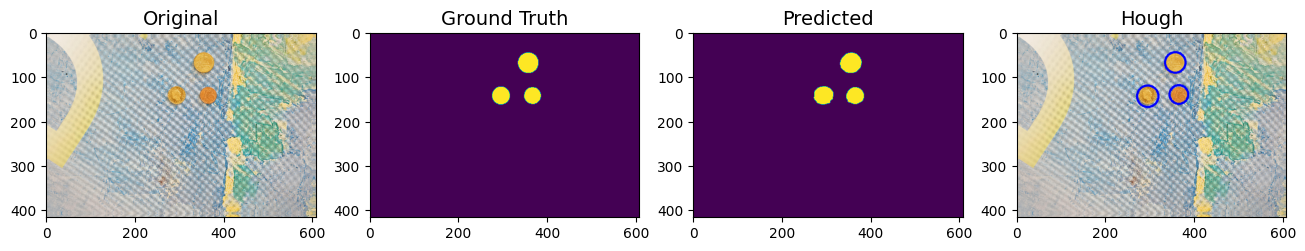

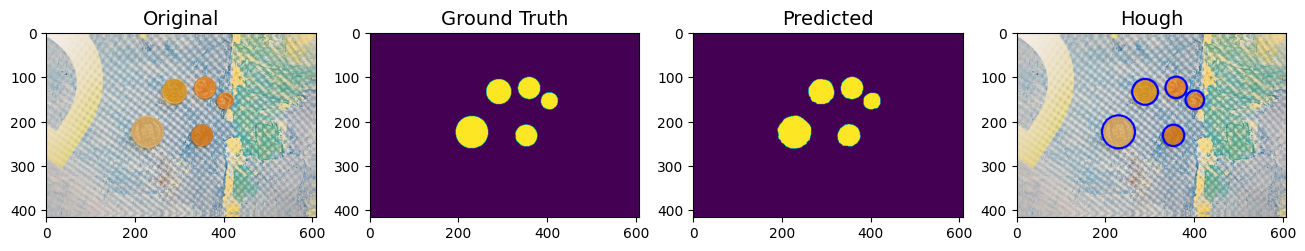

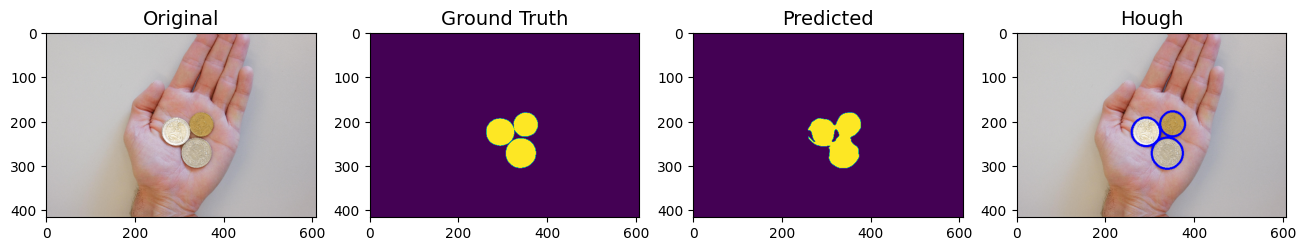

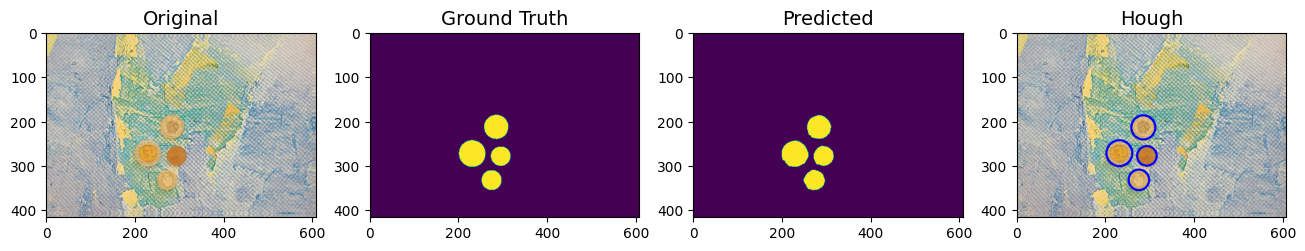

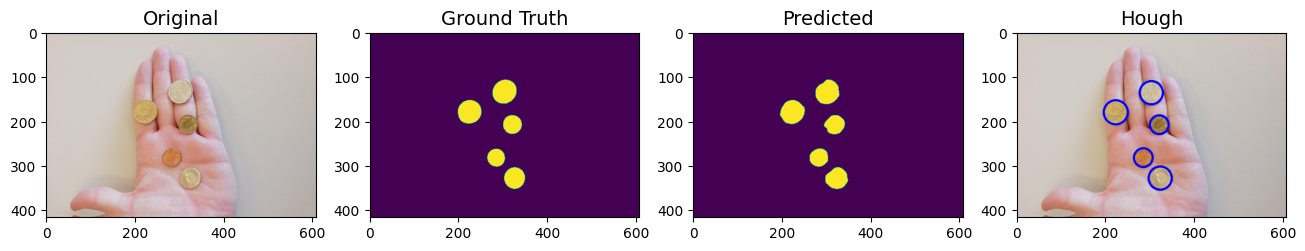

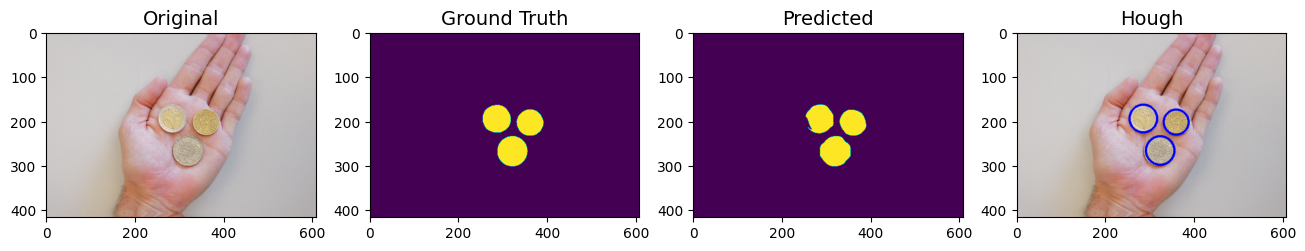

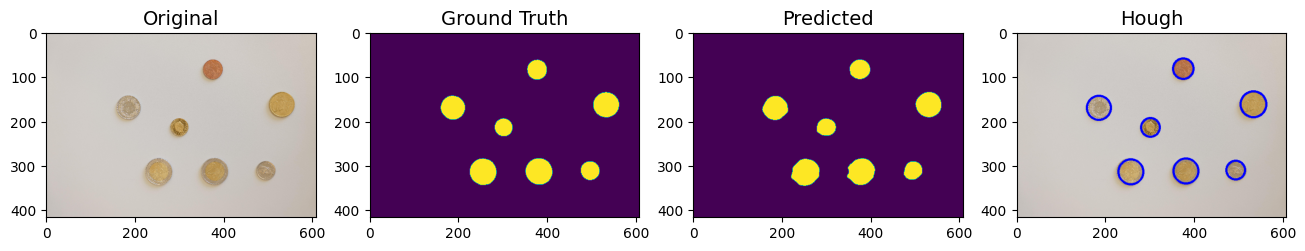

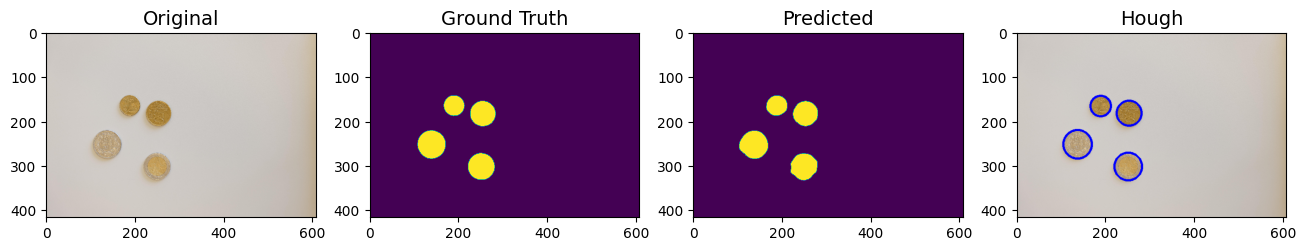

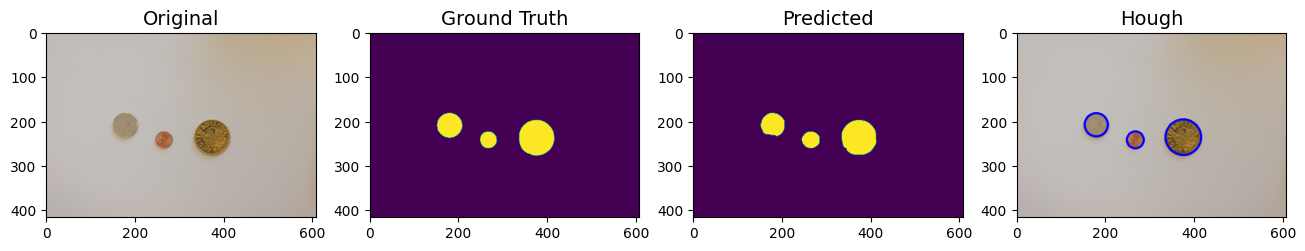

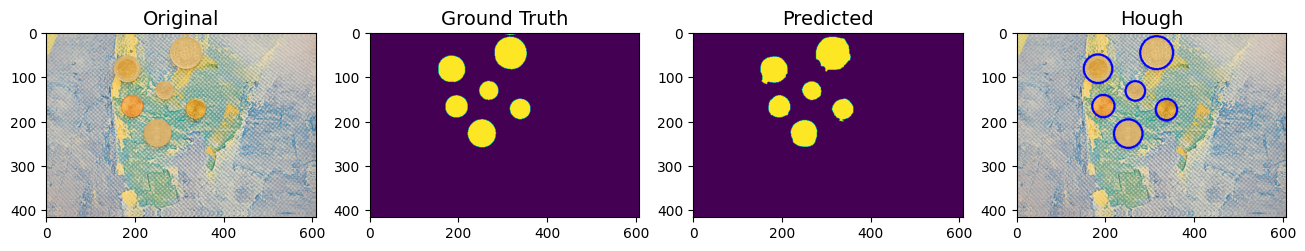

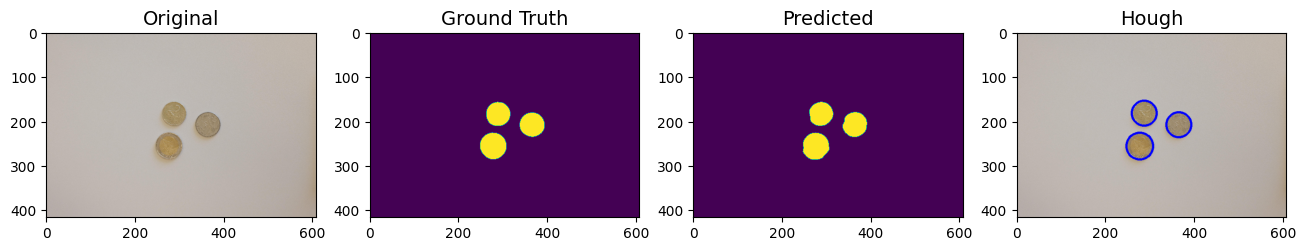

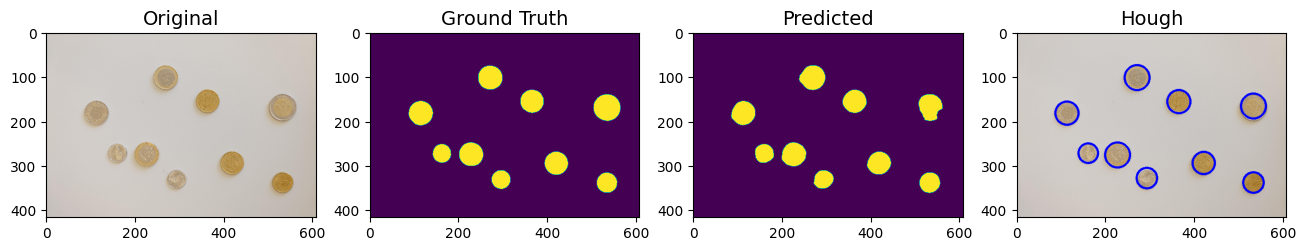

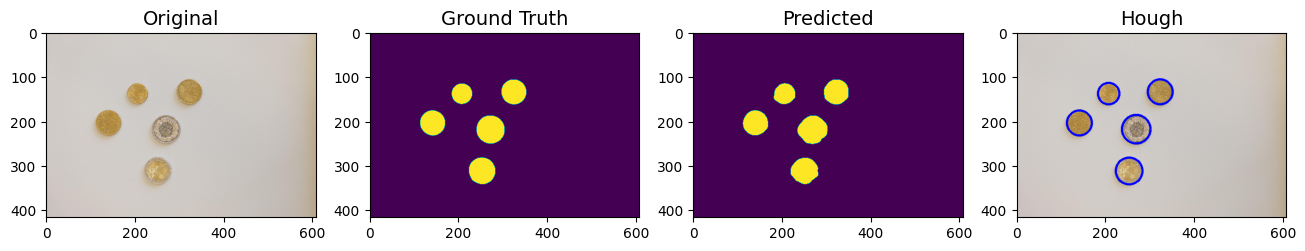

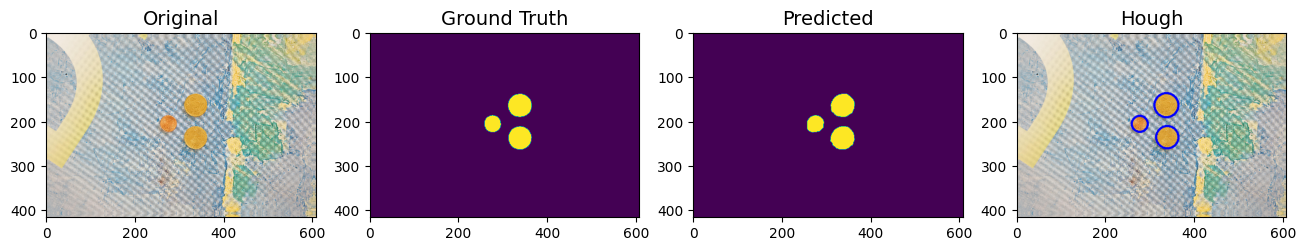

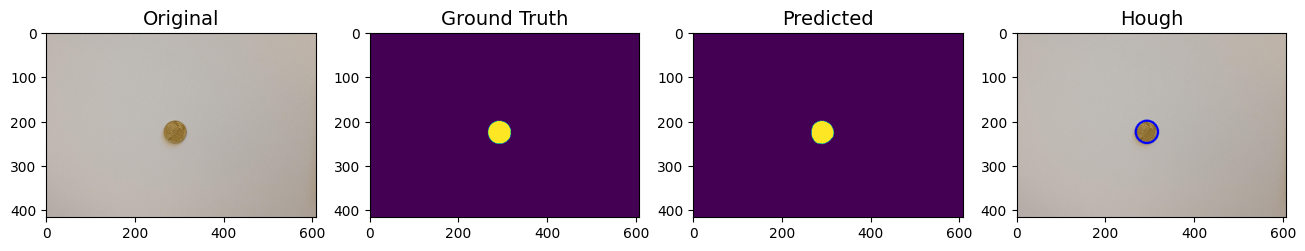

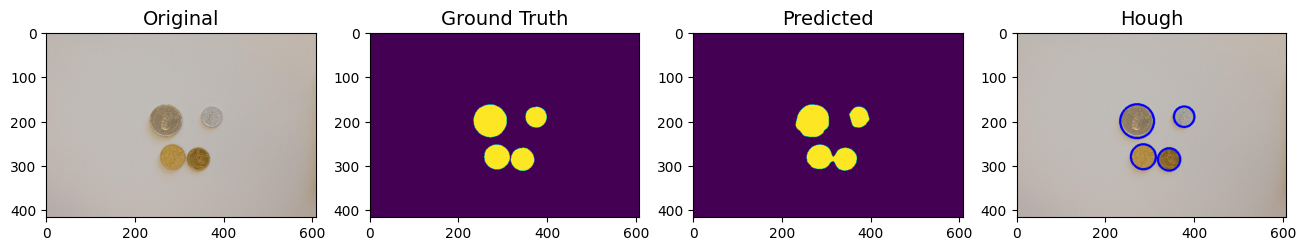

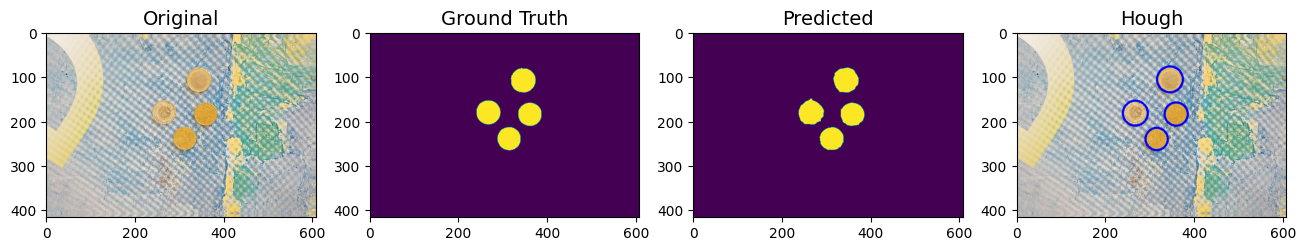

In [24]:
for images, labels in val_loader:
    
    for image, label in zip(images, labels):

        predicted = get_prediction(model, image.unsqueeze(0))
        
        circles = cv.HoughCircles((predicted * 255).astype(np.uint8), cv.HOUGH_GRADIENT, 1, 20, param1=200, param2=10, minRadius=15, maxRadius=55)
        circles = filter_circles(circles)
        
        hough_img = image.numpy().copy().transpose(1, 2, 0)
        hough_img = cv.cvtColor(hough_img, cv.COLOR_BGR2RGB) 
        
        for (x, y, r) in circles:
            cv.circle(hough_img, (x, y), r, (255, 0, 0), 4)
    
        plot_images(
            original=image,
            ground_truth=label,
            predicted=predicted,
            hough=hough_img[:, :, ::-1]  # bgr -> rgb
        )